In [69]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import torch
import xgboost as xgb
from PIL import Image
from numpy.typing import NDArray
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
from umap import UMAP
from sklearn.preprocessing import LabelEncoder




RuntimeError: Failed to import transformers.models.auto.image_processing_auto because of the following error (look up to see its traceback):
cannot import name 'DiagnosticOptions' from 'torch.onnx._internal.exporter' (/Users/zhaniko/miniconda3/lib/python3.12/site-packages/torch/onnx/_internal/exporter/__init__.py)

In [66]:
!pip install --upgrade transformers


In [ ]:
#Dicrise size of data
def project_vectors(data: NDArray, technique: str = "tsne", **options) -> NDArray:
    if technique == "pca":
        transformer = PCA(**options)
    elif technique == "tsne":
        transformer = TSNE(**options)
    elif technique == "umap":
        transformer = UMAP(**options)
    else:
        raise ValueError(
            f"Invalid technique: {technique}. Choose from 'pca', 'tsne', or 'umap'."
        )

    transformed_data = transformer.fit_transform(data)
    return transformed_data

In [ ]:
pio.renderers.default = "browser"
print(torch.cuda.is_available())

In [30]:
path = Path("/Users/dauren/Downloads/olx_car_analyze-main/data/raw/olx_cars.csv")
df = pd.read_csv(path)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (249, 9)


title  price_pln  brand  \
0                              Ford focus se 165 KM      29900    NaN   
1                              Ford focus se 165 KM      29900    NaN   
2  Alfa Romeo Stelvio Salon Polska Jeden właściciel     119900    NaN   
3  Alfa Romeo Stelvio Salon Polska Jeden właściciel     119900    NaN   
4                       Volvo XC60 3,2 benzyna 2013      45000    NaN   

     model  year  mileage_km     fuel  transmission  \
0    Focus  2016       76000  Benzyna  Automatyczna   
1    Focus  2016       76000  Benzyna  Automatyczna   
2  Stelvio  2021       93000  Benzyna  Automatyczna   
3  Stelvio  2021       93000  Benzyna  Automatyczna   
4       60  2013      200000  Benzyna  Automatyczna   

                                           image_url  
0  https://ireland.apollo.olxcdn.com:443/v1/files...  
1  https://ireland.apollo.olxcdn.com:443/v1/files...  
2  https://ireland.apollo.olxcdn.com:443/v1/files...  
3  https://ireland.apollo.olxcdn.com:443/v1/files...  
4  https://ireland.apollo.olxcdn.com:443/v1/files...

In [5]:
from pathlib import Path
path = Path("/Users/dauren/Downloads/olx_car_analyze-main/data/raw/images")
paths_to_images = list(path.glob("**/*.jpg"))
print("Number of images:", len(paths_to_images))
assert len(paths_to_images) > 0, "No images found in the dataset."

Number of images: 249


In [6]:
path_df = pd.DataFrame(paths_to_images, columns=["path"])
path_df['class'] = path_df['path'].apply(lambda x: x.parent.name)
path_df['class'] = path_df['class'].astype("category")
path_df = path_df.sample(n=248).reset_index(drop=True)
path_df


path    class
0    /Users/dauren/Downloads/olx_car_analyze-main/d...    yaris
1    /Users/dauren/Downloads/olx_car_analyze-main/d...      i20
2    /Users/dauren/Downloads/olx_car_analyze-main/d...        6
3    /Users/dauren/Downloads/olx_car_analyze-main/d...  orlando
4    /Users/dauren/Downloads/olx_car_analyze-main/d...      208
..                                                 ...      ...
243  /Users/dauren/Downloads/olx_car_analyze-main/d...   passat
244  /Users/dauren/Downloads/olx_car_analyze-main/d...    klasa
245  /Users/dauren/Downloads/olx_car_analyze-main/d...  impreza
246  /Users/dauren/Downloads/olx_car_analyze-main/d...       q5
247  /Users/dauren/Downloads/olx_car_analyze-main/d...      i30

[248 rows x 2 columns]

In [8]:
def generate_image_embeddings_with_dinov2(
        image_paths: list[str | Path],
        model_name: str = "facebook/dinov2-base",
        batch_size: int = 1
) -> np.ndarray:
    """
    Generate embeddings for a batch of images using a pretrained DINOv2 model with CUDA support.

    Args:
        image_paths (List[str | Path]): List of image file paths.
        model_name (str): Name of the pretrained model to use. Default is "facebook/dinov2-base".
        batch_size (int): Number of images to process per batch. Default is 1.

    Returns:
        np.ndarray: 2D array of image embedding vectors (num_images, embedding_dim).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    all_embeddings = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        images = [Image.open(path).convert("RGB") for path in batch_paths]

        inputs = processor(images=images, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # DINOv2 outputs `last_hidden_state` (batch_size, seq_len, hidden_dim)
        # We mean-pool over the sequence (excluding the [CLS] token if present)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings).squeeze()


embeddings = generate_image_embeddings_with_dinov2(path_df.path.tolist(), batch_size=16,
                                                   model_name="facebook/dinov2-base")

Using device: cpu


100%|██████████| 16/16 [00:33<00:00,  2.10s/it]


In [9]:
embeddings.shape

(248, 768)

In [32]:
def generate_image_embeddings_as_histograms(image_paths: list[str | Path]):
    """
    Generate embeddings for an image using a pretrained model from HuggingFace.
    
    Args:
        image_paths (list[str | Path]): List of image file paths.
    
    Returns:
        numpy.ndarray: Image embeddings matrix of shape (num_images, 256).
    """
    histograms = []
    for image_path in tqdm(image_paths):
        image = Image.open(image_path)
        image = image.resize((224, 224))

        # Convert image to numpy array
        image = np.array(image)

        # Create histogram
        histogram, _ = np.histogram(image, bins=256, range=(0, 256))
        histograms.append(histogram)

    return np.vstack(histograms).squeeze()


embeddings = generate_image_embeddings_as_histograms(path_df.path.tolist())

100%|██████████| 248/248 [00:08<00:00, 30.99it/s]


In [11]:
#function for visualizing image embeddings using t-SNEP
def plot_embeddings(embeddings: NDArray,
                    additional_columns: dict[str, list[any]] = None,
                    map_columns_as_categories: list[str] = None,
                    reduce_technique: str = "tsne",
                    symbol: str = None,
                    color: str = None,
                    hover_data: list[str] = None,
                    plot_3d: bool = False
                    ):
    if additional_columns is None:
        additional_columns = {}

    for column_name, column_data in additional_columns.items():
        if len(column_data) != embeddings.shape[0]:
            raise ValueError(f"Length of column data for '{column_name}' does not match number of embeddings.")

    for on_hover_column_name in hover_data:
        if on_hover_column_name not in additional_columns:
            raise ValueError(f"Column '{on_hover_column_name}' not found in additional columns.")

    
    if embeddings.shape[1] > 2:
        reduced_embeddings = project_vectors(embeddings, technique=reduce_technique,
                                             n_components=3 if plot_3d else 2, random_state=6)
        print(f"Reduced embeddings from {embeddings.shape[1]} to {reduced_embeddings.shape[1]}")
    else:
        reduced_embeddings = embeddings
        
    df = pd.DataFrame({
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],

        "z": reduced_embeddings[:, 2] if plot_3d else None,

        **additional_columns
    })

    df = df.astype(
        {col: "category" for col in df.select_dtypes(include=["object", "category"]).columns}
    )
    
    
    
    if map_columns_as_categories is not None:
        df = df.astype(
            {col: "category" for col in map_columns_as_categories}
        )

    if plot_3d:
        fig = px.scatter_3d(df, x="x", y="y", z="z", color=color, symbol=symbol,
                            title=f"{reduce_technique} reduction technique. Visualization of Image Embeddings",
                            hover_data=hover_data)
    else:
        fig = px.scatter(df, x="x", y="y", color=color, symbol=symbol,
                         title=f"{reduce_technique} reduction technique. Visualization of Image Embeddings",
                         hover_data=hover_data
                         
                         
                         )

    fig.update_traces(textfont_size=25, marker=dict(size=25))
    fig.update_layout(template="plotly")
    fig.show()


plot_embeddings(embeddings,
                additional_columns={
                    "class": path_df["class"].tolist(),
                    "path": list(map(lambda d: str(d), path_df["path"].tolist())),
                },
                color="class",
                hover_data=["path", "class"],
                plot_3d=False,
                reduce_technique="tsne"
                )

Reduced embeddings from 256 to 2


In [34]:

#Created a mapping system to replace string labels with numeric values and vice versa. It is useful for:
#Data transformations for machine learning model training.
#Restoring the original labels after the model's predictions.
#Words to index and index to words
unique_labels = path_df["class"].unique()
# print("Unique labels:", unique_labels)
label_mapping  = {label: idx for idx, label in enumerate(unique_labels)}
labels = path_df["class"].map(label_mapping)
reverse_label_mapping = { value:key for key, value in label_mapping.items()}
label_mapping

{'yaris': 0,
 'i20': 1,
 '6': 2,
 'orlando': 3,
 '208': 4,
 '5': 5,
 'twingo': 6,
 'leon': 7,
 'berlingo': 8,
 'c1': 9,
 '3': 10,
 'passat': 11,
 'corolla': 12,
 'corsa': 13,
 'rav-4': 14,
 'laguna': 15,
 '80': 16,
 'astra': 17,
 'uno': 18,
 'auris': 19,
 'qashqai': 20,
 'a5': 21,
 'mondeo': 22,
 'altea': 23,
 'navara': 24,
 'cooper': 25,
 'fabia': 26,
 'i30': 27,
 'octavia': 28,
 '600': 29,
 'klasa': 30,
 'cruiser': 31,
 'mercedes': 32,
 'touran': 33,
 'vitara': 34,
 'taurus': 35,
 'x': 36,
 'x6': 37,
 'espace': 38,
 'golf': 39,
 'a4': 40,
 'multivan': 41,
 'q5': 42,
 'escape': 43,
 'cruze': 44,
 'rio': 45,
 'plus': 46,
 'colt': 47,
 'focus': 48,
 'chevrolet': 49,
 'sport': 50,
 '60': 51,
 'sharan': 52,
 'tt': 53,
 'ranger': 54,
 'vaneo': 55,
 'cherokee': 56,
 'trafic': 57,
 'avensis': 58,
 'viano': 59,
 'cr-v': 60,
 'caravelle': 61,
 'beetle': 62,
 'partner': 63,
 'insignia': 64,
 'stelvio': 65,
 '500': 66,
 '508': 67,
 'kangoo': 68,
 'a3': 69,
 'nan': 70,
 's-max': 71,
 'a6': 72,
 '

In [13]:
#I used the Counter from the collections library to count how many times each label occurs in the labels column.
from collections import Counter
print(Counter(labels))


Counter({10: 16, 22: 10, 30: 10, 11: 6, 19: 6, 21: 6, 28: 6, 34: 6, 39: 6, 46: 6, 48: 6, 5: 5, 0: 4, 4: 4, 12: 4, 13: 4, 20: 4, 26: 4, 33: 4, 40: 4, 51: 4, 52: 4, 57: 4, 1: 2, 2: 2, 3: 2, 6: 2, 7: 2, 8: 2, 9: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 23: 2, 24: 2, 25: 2, 27: 2, 29: 2, 31: 2, 32: 2, 35: 2, 36: 2, 37: 2, 38: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 47: 2, 49: 2, 50: 2, 53: 2, 54: 2, 55: 2, 56: 2, 58: 2, 59: 2, 60: 2, 61: 2, 62: 2, 63: 2, 64: 2, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 75: 1})


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[13:09:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




F1 Score: 0.8750

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      0.60      0.75         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       0.60      1.00      0.75         3
           6       1.00      1.00      1.00         2
           7       1.00      0.33      0.50         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         1

    accuracy                           0.85        27
   macro avg       0.91      0.91      0.88        27
weighted avg       0.93      0.85      0.85        27



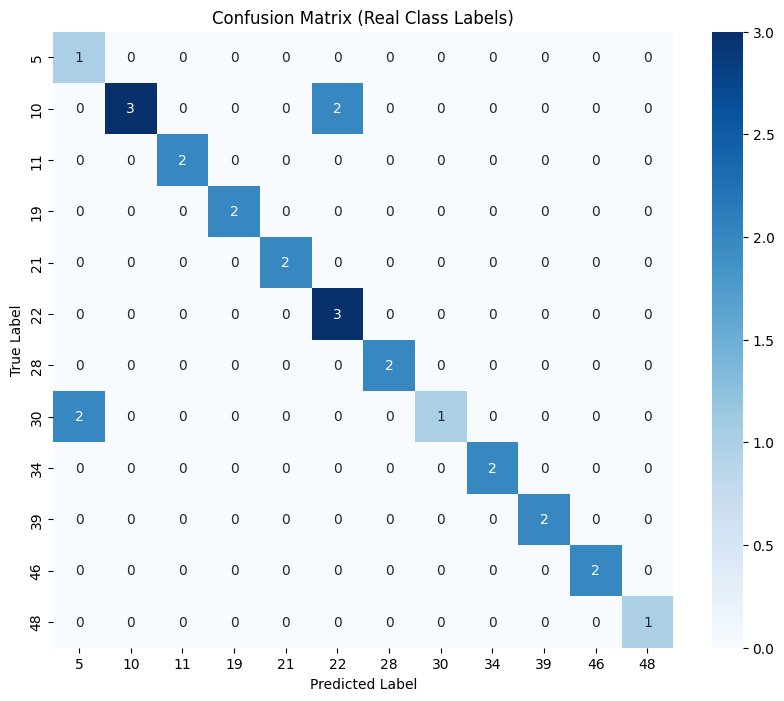

In [35]:
# Этап 1: Filtr 
label_counts = Counter(labels)
allowed_labels = {label for label, count in label_counts.items() if count >= 5}
valid_indices = [i for i, label in enumerate(labels) if label in allowed_labels]

filtered_embeddings = [embeddings[i] for i in valid_indices]
filtered_labels = [labels[i] for i in valid_indices]

# Кодировка классов
le = LabelEncoder()
encoded_labels = le.fit_transform(filtered_labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    filtered_embeddings,
    encoded_labels,
    test_size=0.3,
    stratify=encoded_labels,
    shuffle=True,
    random_state=42
)

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
accuracy = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

labels_order = le.classes_  # это оригинальные метки до кодировки
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order, yticklabels=labels_order)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Real Class Labels)')
plt.show()

#Data Filtering: Retains only those classes that appear at least 5 times.
#Label Encoding: Converts string labels to numeric values.
#Train/Test Split: Splits the data into training and testing sets (70/30).
#Training the XGBoost Model: Trains a classifier on the training data.
#Model Evaluation: Calculates the F1-Score and generates a classification report.
#Visualization: Plots a confusion matrix showing the model's prediction accuracy.


Predicted class idx: 0
Predicted class name: 5


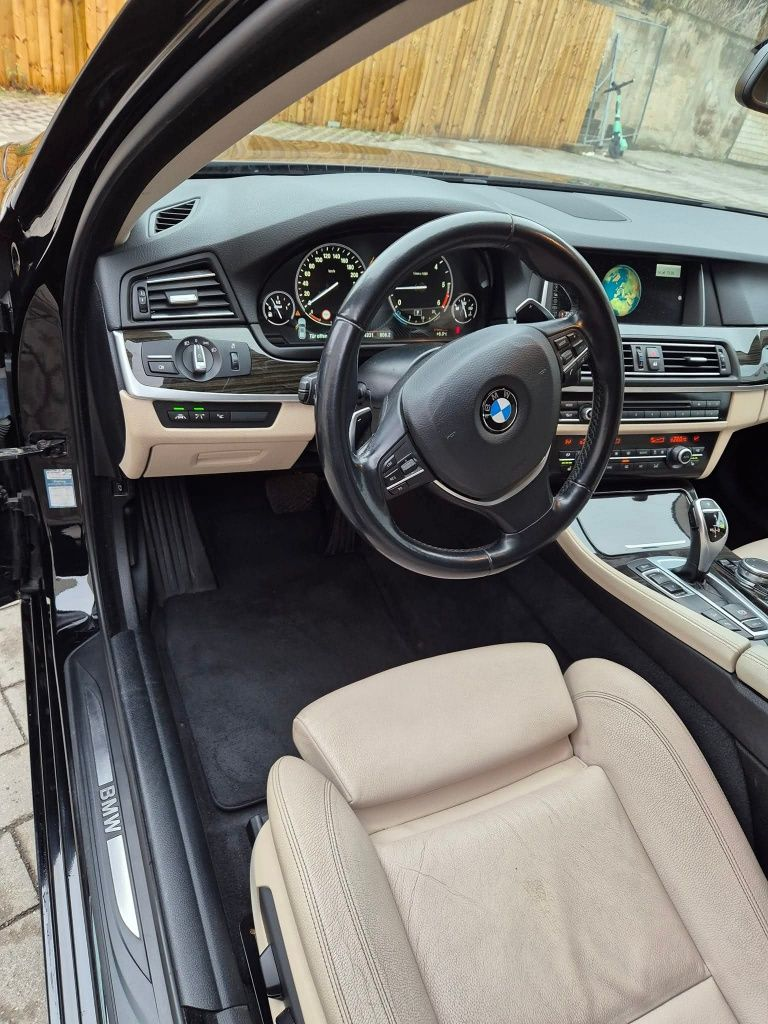

In [20]:
#This code selects the first image from the filtered dataset, passes it through the trained XGBoost model, the image for visual verification.
example_local_idx = 0 
example_global_idx = valid_indices[example_local_idx]
example_image_path = path_df.iloc[example_global_idx]["path"]
example_image_embedding = filtered_embeddings[example_local_idx]

example_input = np.array(example_image_embedding).reshape(1, -1)
y_pred_single = xgb_clf.predict(example_input)
predicted_label = le.inverse_transform(y_pred_single)[0]

print("Predicted class idx:", y_pred_single[0])
print("Predicted class name:", predicted_label)

Image.open(example_image_path)


Top 10 labels: [10, 22, 30, 11, 19, 21, 28, 34, 39, 46]
Training data shape: (54, 256)
Testing data shape: (24, 256)

F1 Score (macro): 0.29439393939393943

Classification Report:
              precision    recall  f1-score   support

          10       0.67      0.80      0.73         5
          11       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         1
          21       1.00      0.50      0.67         2
          22       1.00      0.33      0.50         3
          28       0.00      0.00      0.00         2
          30       0.00      0.00      0.00         3
          34       0.00      0.00      0.00         2
          39       0.17      0.50      0.25         2
          46       0.67      1.00      0.80         2

    accuracy                           0.38        24
   macro avg       0.35      0.31      0.29        24
weighted avg       0.42      0.38      0.36        24



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



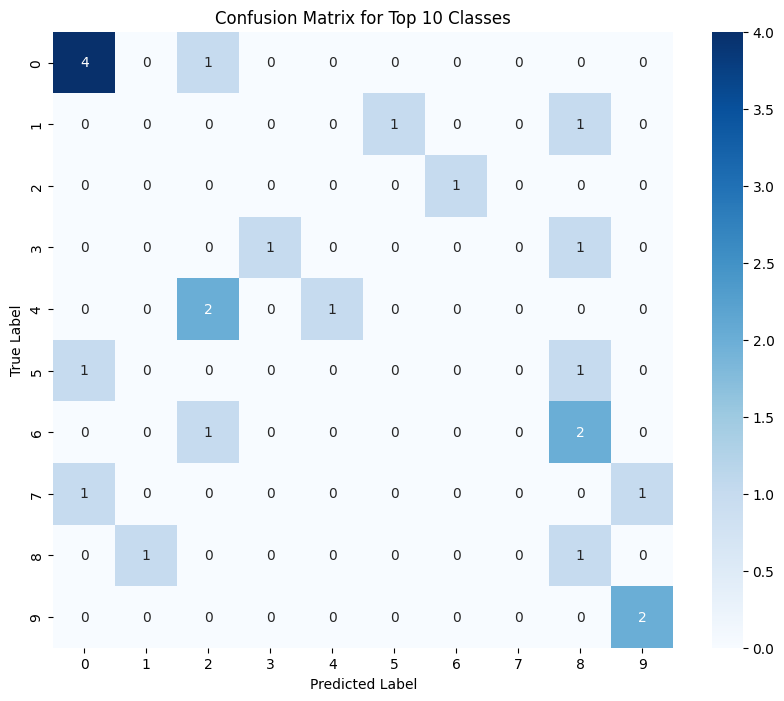

In [23]:
#Step 1: We find the top 10 most frequent classes in the data.
#Step 2: Filter the data, leaving only these classes.
#Step 3: Divide the data into training and test samples.
#Step 4: Train the KNN classifier on the filtered data.
label_counter = Counter(labels)
top_10_labels = [label for label, count in label_counter.most_common(10)]
print("Top 10 labels:", top_10_labels)

# Шаг 2: Отфильтруем только эти классы
filtered_indices = [i for i, lbl in enumerate(labels) if lbl in top_10_labels]
filtered_embeddings = [embeddings[i] for i in filtered_indices]
filtered_labels = [labels[i] for i in filtered_indices]

# Шаг 3: Разделим данные
X_train, X_test, y_train, y_test = train_test_split(
    filtered_embeddings,
    filtered_labels,
    test_size=0.3,
    stratify=filtered_labels,
    shuffle=True,
    random_state=42
)

print(f"Training data shape: {np.array(X_train).shape}")
print(f"Testing data shape: {np.array(X_test).shape}")

# Шаг 4: Обучение KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Предсказание
y_pred = knn_clf.predict(X_test)

# F1
print("\nF1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Top 10 Classes')
plt.show()


We need to add one dimension: (1, 256)
Predicted class idx: 46
Predicted class name: plus


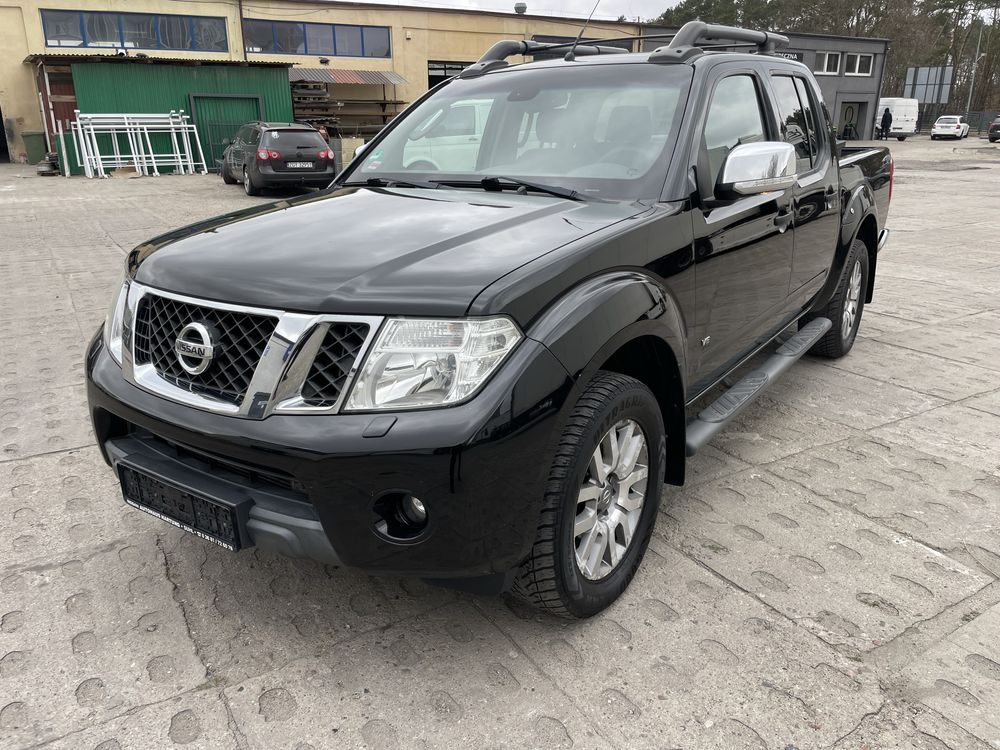

In [24]:
#Here we have displayed the image using the KNN learning model with an index of 26
example_idx = 26
example_image_path = path_df.iloc[example_idx]["path"]
example_image_embedding = embeddings[example_idx]
print("We need to add one dimension:", example_image_embedding.reshape(1, -1).shape)
y_pred = knn_clf.predict(example_image_embedding.reshape(1, -1))
print("Predicted class idx:", y_pred[0])
print("Predicted class name:", reverse_label_mapping[y_pred[0].item()])
Image.open(example_image_path)

In [25]:
#This feature provides a flexible way to cluster embeddings using various algorithms and additional parameters for configuring clustering.
def cluster_embeddings(embeddings: NDArray, algorithm_name: str = 'KMeans', **kwargs):
    """
    Clusters embeddings using a specified clustering algorithm from sklearn.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        The embeddings to cluster, shape (n_samples, n_features)
    algorithm_name : str
        Name of the clustering algorithm to use (must be available in sklearn.cluster
        or be GaussianMixture)
    **kwargs : 
        Additional parameters to pass to the clustering algorithm
        
    Returns:
    --------
    labels : numpy.ndarray
        Cluster labels for each embedding, shape (n_samples,)
    model : object
        The fitted clustering model
    """
    if not isinstance(embeddings, np.ndarray):
        raise TypeError("Embeddings must be a numpy array")

    if len(embeddings.shape) != 2:
        raise ValueError(f"Embeddings must be 2D array, got shape {embeddings.shape}")

    if algorithm_name == 'GaussianMixture':
        algorithm_class = GaussianMixture
    else:
        try:
            algorithm_class = getattr(cluster, algorithm_name)
        except AttributeError:
            raise ValueError(f"Algorithm '{algorithm_name}' not found in sklearn.cluster or is not GaussianMixture")

    model = algorithm_class(**kwargs)

    if hasattr(model, 'fit_predict'):
        labels = model.fit_predict(embeddings)
    elif hasattr(model, 'fit') and hasattr(model, 'predict'):

        model.fit(embeddings)
        labels = model.predict(embeddings)
    else:
        raise ValueError(f"Algorithm '{algorithm_name}' does not support required methods")

    return labels, model


In [26]:
#Clustering: All embeddings will be divided into 7 clusters, and each object will receive a corresponding label.
#Visualization: You will get a graph on which:
#The points will be separated by color depending on their cluster.
#The dot symbols will indicate which class they belong to.
#When you hover over a point, you can see the path to the image.
clustering_results, model1 = cluster_embeddings(embeddings, 'KMeans', n_clusters=7)
print(f"KMeans labels shape: {clustering_results.shape}, unique clusters: {np.unique(clustering_results)}")

plot_embeddings(embeddings,
                additional_columns={
                    "class": path_df["class"].tolist(),
                    "path": list(map(str, path_df["path"].tolist())),
                    # "path": path_df["path"].tolist(),
                    "cluster": clustering_results.tolist()
                },
                color="cluster",
                symbol="class",
                hover_data=["path"],
                map_columns_as_categories=["cluster"]
                )

KMeans labels shape: (248,), unique clusters: [0 1 2 3 4 5 6]
Reduced embeddings from 256 to 2


In [27]:
adjusted_rand_score(clustering_results, labels)

0.03836892026910426

In [28]:
clustering_results

array([3, 6, 5, 6, 6, 4, 0, 5, 3, 3, 5, 5, 0, 5, 3, 3, 3, 5, 5, 5, 5, 6,
       0, 3, 5, 5, 0, 6, 6, 3, 5, 5, 5, 0, 3, 5, 5, 6, 6, 5, 6, 6, 6, 6,
       4, 6, 4, 4, 4, 3, 5, 5, 4, 0, 0, 5, 6, 5, 4, 5, 6, 3, 3, 6, 6, 0,
       4, 0, 4, 0, 5, 0, 6, 6, 5, 0, 4, 5, 6, 5, 3, 3, 4, 0, 3, 6, 5, 6,
       0, 0, 5, 0, 0, 0, 5, 0, 3, 6, 6, 6, 3, 0, 4, 4, 0, 3, 3, 5, 3, 3,
       6, 0, 5, 0, 4, 0, 4, 6, 6, 6, 5, 0, 0, 6, 6, 0, 4, 0, 5, 3, 0, 5,
       3, 0, 5, 5, 0, 3, 6, 4, 3, 6, 0, 3, 6, 5, 3, 6, 5, 4, 3, 6, 3, 6,
       5, 5, 6, 6, 4, 4, 6, 3, 0, 0, 0, 4, 3, 4, 3, 0, 3, 0, 6, 3, 3, 3,
       6, 4, 0, 6, 5, 0, 6, 6, 4, 4, 6, 5, 5, 4, 3, 0, 0, 6, 3, 0, 3, 6,
       6, 6, 0, 5, 6, 3, 6, 2, 6, 5, 6, 6, 4, 5, 3, 1, 6, 5, 0, 6, 5, 1,
       5, 6, 0, 5, 6, 3, 5, 3, 6, 3, 0, 2, 6, 5, 0, 5, 5, 3, 3, 6, 6, 0,
       6, 5, 5, 3, 5, 5], dtype=int32)

PC1: 0.4194 (0.4194 cumulative)
PC2: 0.3321 (0.7516 cumulative)
PC3: 0.0551 (0.8067 cumulative)
PC4: 0.0463 (0.8530 cumulative)
PC5: 0.0282 (0.8812 cumulative)
PC6: 0.0269 (0.9081 cumulative)
PC7: 0.0180 (0.9261 cumulative)
PC8: 0.0118 (0.9380 cumulative)
PC9: 0.0110 (0.9489 cumulative)
PC10: 0.0100 (0.9589 cumulative)
PC11: 0.0075 (0.9664 cumulative)
PC12: 0.0057 (0.9721 cumulative)
PC13: 0.0039 (0.9760 cumulative)
PC14: 0.0029 (0.9788 cumulative)
PC15: 0.0028 (0.9817 cumulative)
PC16: 0.0024 (0.9841 cumulative)
PC17: 0.0021 (0.9862 cumulative)
PC18: 0.0017 (0.9879 cumulative)
PC19: 0.0014 (0.9893 cumulative)
PC20: 0.0012 (0.9905 cumulative)
PC21: 0.0011 (0.9916 cumulative)
PC22: 0.0009 (0.9925 cumulative)
PC23: 0.0008 (0.9933 cumulative)
PC24: 0.0006 (0.9939 cumulative)
PC25: 0.0005 (0.9945 cumulative)
PC26: 0.0005 (0.9949 cumulative)
PC27: 0.0004 (0.9954 cumulative)
PC28: 0.0003 (0.9957 cumulative)
PC29: 0.0003 (0.9960 cumulative)
PC30: 0.0003 (0.9963 cumulative)
PC31: 0.0003 (0.996

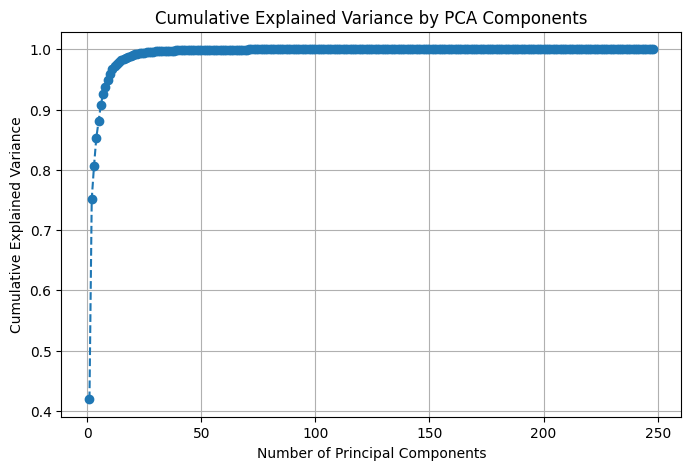

In [29]:
#In this code, I applied the PCA method to reduce the dimension of image embeddings and analyze how much data variance is explained by each component.
pca = PCA()
X_pca = pca.fit_transform(embeddings)

# Step 3: Variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print results
for i, (ev, cum) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC{i+1}: {ev:.4f} ({cum:.4f} cumulative)")

# Optional: Plot variance explained
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()